In [1]:
# PCA and preprocessing modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from rdkit.Chem import Descriptors
from rdkit import Chem
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_selection import RFECV


# Models
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from scipy.ndimage import gaussian_filter1d

# k-Nearest Neighbours
from sklearn.neighbors import KNeighborsClassifier

# Support Vector Clustering
from sklearn.svm import SVC

# Preprocessing

### Reading files into dataframes 

In [2]:
# Read file
original_df = pd.read_csv('tested_molecules_1.csv')

# Split the column
original_df[['SMILES', 'ALDH1_inhibition']] = original_df['SMILES,"ALDH1_inhibition"'].str.split(',', expand=True)
original_df.drop('SMILES,"ALDH1_inhibition"', axis=1, inplace=True)

original_df['ALDH1_inhibition'] = original_df['ALDH1_inhibition'].str.strip('"')
# Read file for original_df_test
original_df_test = pd.read_csv('tested_molecules_2.csv')

original_df_test = pd.read_csv('tested_molecules_2.csv')
original_df_test[['SMILES', 'ALDH1_inhibition']] = original_df_test['SMILES;ALDH1_inhibition'].str.split(';', expand=True)
original_df_test.drop('SMILES;ALDH1_inhibition', axis=1, inplace=True)

combined_df = pd.concat([original_df, original_df_test], ignore_index=True)

X = combined_df.drop('ALDH1_inhibition', axis=1)
y = combined_df['ALDH1_inhibition']

all_descriptors = [desc[0] for desc in Descriptors.descList]
descriptor_data_list_original = []
for i, row in X.iterrows():
    mol = Chem.MolFromSmiles(row['SMILES'])
    descriptor_values = [getattr(Descriptors, descriptor)(mol) for descriptor in all_descriptors]
    descriptor_data_list_original.append(descriptor_values)

descriptor_df = pd.DataFrame(descriptor_data_list_original, columns=all_descriptors)

### Preprocessing

In [3]:
new_df_variables = descriptor_df.copy()
corr_matrix = new_df_variables.corr().abs() #Numeric_only=True removed, because it gave an error
mask = np.triu(np.ones(corr_matrix.shape, dtype=bool), k=1)

# Select upper triangle of correlation matrix using the boolean mask
upper = corr_matrix.where(mask)

# Find index of columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop the columns
new_df_variables.drop(columns=to_drop, inplace=True)

In [4]:
# Scaling the data 
df_copied = new_df_variables.copy()
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_copied)
df_scaled = pd.DataFrame(df_scaled, columns=df_copied.columns)

In [5]:
def remove_features_with_low_variance(data, threshold):
    low_variance_features = []
    
    for feature in data.columns:
        var = data[feature].var()
        
        if var < threshold:
            low_variance_features.append(feature)
    
    # Remove the features with low variance
    data = data.drop(low_variance_features, axis=1)
    
    return data
data_filtered = remove_features_with_low_variance(df_scaled, threshold=0.005)


In [6]:
# Function coded with help from GPT-4
def remove_features_with_outliers(data, threshold):
    outlier_count = []
    features_to_remove = []
    
    for feature in data.columns:
        # Calculate the IQR (Interquartile Range) for the current feature
        Q1 = data[feature].quantile(0.25)
        Q3 = data[feature].quantile(0.75)
        IQR = Q3 - Q1
        
        # Define the lower and upper bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Count the number of outliers
        outliers_count = ((data[feature] < lower_bound) | (data[feature] > upper_bound)).sum()
        
        # Append the feature and its outlier count to the list
        outlier_count.append((feature, outliers_count))
        
        # Check if the feature has more outliers than the threshold
        if outliers_count > threshold:
            features_to_remove.append(feature)
    
    # Sort the features based on the outlier count (from lowest to highest)
    outlier_count.sort(key=lambda x: x[1])
    
    # Remove the features with more outliers than the threshold
    data = data.drop(features_to_remove, axis=1)
    
    return data
data_filtered = remove_features_with_outliers(data_filtered, 90)

In [7]:
# Calculate the mean for each column
mean = data_filtered.mean()

# Calculate the standard deviation for each column
std_dev = data_filtered.std()

# Iterate over each column in the dataframe
outlier_features = []
for column in data_filtered.columns:
    # Calculate the absolute difference between values and the mean
    diff = abs(data_filtered[column] - mean[column])
    
    # Check if the difference is more than four standard deviations
    if (diff > 8 * std_dev[column]).any():
        outlier_features.append(column)

# Drop the outlier features from the dataframe
data_filtered = data_filtered.drop(columns=outlier_features)

Calculating optimal features with RFECV

In [8]:
X = data_filtered
boosting_estimator = AdaBoostClassifier(n_estimators=100, random_state=42)

# Create RFECV with the AdaBoost classifier as the estimator
rfecv = RFECV(estimator=boosting_estimator, cv=5, step=1, scoring='accuracy')

# Fit RFECV on the training data
rfecv.fit(X, y)

# Get the selected features
selected_features = X.columns[rfecv.support_]

print('Optimal number of features:', rfecv.n_features_)
print('Best features:', selected_features)

# Fit AdaBoost on the training data
boosting_estimator.fit(X, y)

# Calculate feature importances
feature_importances = boosting_estimator.feature_importances_

df_selected_features = data_filtered.loc[:, selected_features]

Optimal number of features: 18
Best features: Index(['MaxEStateIndex', 'qed', 'MolWt', 'MaxPartialCharge',
       'MinPartialCharge', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI',
       'BCUT2D_MRHI', 'BalabanJ', 'BertzCT', 'Kappa2', 'PEOE_VSA7', 'SMR_VSA1',
       'SMR_VSA10', 'SlogP_VSA5', 'VSA_EState8', 'MolLogP'],
      dtype='object')


## PCA

In [9]:
# Create principal components
pca = PCA()
df_pca = pca.fit_transform(df_selected_features)
# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(df_pca.shape[1])]
df_pca_converted = pd.DataFrame(df_pca, columns=component_names)

df_pca_converted.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18
0,0.524092,0.137517,0.181926,0.125913,-0.184487,-0.004333,0.092854,0.075539,-0.171829,0.005978,0.059888,-0.071555,-0.032207,-0.044872,0.083316,0.105194,-0.015065,0.028838
1,0.174428,0.309373,-0.092610,0.000579,-0.128074,0.083918,0.010308,0.094354,-0.037947,-0.018837,-0.062700,-0.073437,0.090225,-0.005407,-0.008119,0.015137,0.014836,-0.020391
2,0.633657,0.180584,0.539654,0.252055,-0.036576,-0.006382,-0.018049,-0.003968,-0.026050,-0.052728,0.047096,-0.045798,-0.003352,0.144095,-0.013572,-0.002306,0.055732,0.031482
3,0.074288,0.007266,-0.231351,-0.333269,0.231452,0.130549,0.021598,-0.097725,0.098042,-0.042194,0.257006,0.031978,0.167239,0.012117,0.051995,-0.057340,-0.031677,0.028902
4,0.282885,0.294472,-0.179994,-0.333280,0.019560,-0.042268,-0.013266,0.068431,-0.123438,-0.005909,-0.049559,0.030564,-0.114220,0.010742,-0.025426,-0.023814,-0.008350,0.007111


### PCA visualisation plots

(0.3875400502134756, 0.1271640813082535)

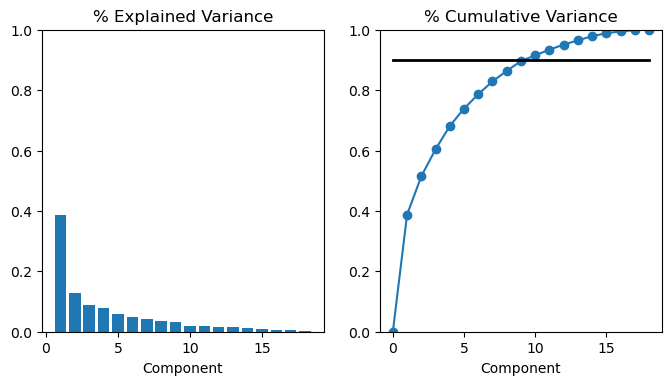

In [10]:
# Create figure
fig, axs = plt.subplots(1, 2)
n = pca.n_components_
grid = np.arange(1, n + 1)

# Explained variance
# Explained variance
evr = pca.explained_variance_ratio_
axs[0].bar(grid, evr)
axs[0].set(
    xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
)

# Cumulative Variance
# Cumaltive Variance
cv = np.cumsum(evr)
axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
axs[1].plot([0, n], [0.9, 0.9], color='k', linestyle='-', linewidth=2)
axs[1].set(
    xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
)
        
# Set up figure
fig.set(figwidth=8, dpi=100);
evr[0],evr[1]

Text(0.5, 1.0, 'Scores separated by ALDH1 inhibition')

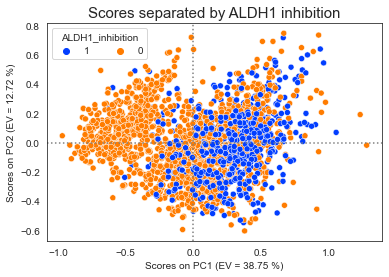

In [11]:
def plot_scores(label, PC_1, PC_2, X, y):
    labels = y.values
    sns.set_style('white')
    sns.scatterplot(x=df_pca[:, PC_1], y=df_pca[:, PC_2], hue=labels, palette='bright')

    plt.axhline(y=0, color='gray', linestyle='dotted')    
    plt.axvline(x=0, color='gray', linestyle='dotted')

    plt.legend(loc='best', ncol=2, title=label)

# Call the function with the appropriate arguments
plot_scores(label='ALDH1_inhibition', PC_1=0, PC_2=1, X=df_pca_converted, y=y)

plt.xlabel('Scores on PC1 (EV = 38.75 %)')
plt.ylabel('Scores on PC2 (EV = 12.72 %)')
plt.title('Scores separated by ALDH1 inhibition', fontsize=15)

# Preparation for models

In [12]:
X = df_pca_converted[['PC1','PC2','PC3']]
y = combined_df['ALDH1_inhibition']

In [13]:
df_pca_converted[['PC1','PC2','PC3']].head()

,PC1,PC2,PC3
0,0.524092,0.137517,0.181926
1,0.174428,0.309373,-0.092610
2,0.633657,0.180584,0.539654
3,0.074288,0.007266,-0.231351
4,0.282885,0.294472,-0.179994


### Importing data to be tested

In [14]:
# Import the dataset to be tested on
test_molecules = pd.read_csv('untested_molecules.csv')

In [15]:
# Documenting all descriptors
all_descriptors = [desc[0] for desc in Descriptors.descList]
descriptor_data_list_original = []

for i, row in test_molecules.iterrows():
    mol = Chem.MolFromSmiles(row['SMILES'])
    descriptor_values = [getattr(Descriptors, descriptor)(mol) for descriptor in all_descriptors]
    descriptor_data_list_original.append(descriptor_values)

# Making dataframe with descriptors 
descriptor_test = pd.DataFrame(descriptor_data_list_original, columns=all_descriptors)

# Removing all features except final features selected during preprocessing
output_selected_features = descriptor_test.loc[:, selected_features]
output_selected_features.head()

,MaxEStateIndex,qed,MolWt,MaxPartialCharge,MinPartialCharge,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_MRHI,BalabanJ,BertzCT,Kappa2,PEOE_VSA7,SMR_VSA1,SMR_VSA10,SlogP_VSA5,VSA_EState8,MolLogP
0,12.089288,0.349176,379.504,0.240089,-0.352016,2.080331,-2.078497,2.088773,6.006437,1.791107,757.931608,12.439441,23.968546,9.589074,17.526044,56.575570,2.623988,4.18380
1,12.797328,0.664725,442.537,0.309039,-0.455341,2.332267,-2.298232,2.278852,7.887355,1.286783,1073.400608,8.802587,49.948755,22.743734,27.587162,23.968546,2.702001,2.52822
2,12.973159,0.499889,359.313,0.296611,-0.496499,2.418534,-2.162707,2.350012,6.236926,1.895160,884.467127,6.788097,36.398202,23.639663,28.876518,6.420822,0.000000,2.48650
3,11.709157,0.247581,358.374,0.393644,-0.481687,2.099290,-2.057211,2.155919,5.772305,1.831575,810.970252,8.610731,42.670563,24.448012,17.492311,16.690354,3.612985,0.72914
4,12.580327,0.376568,334.729,0.417444,-0.354747,2.318223,-2.297318,2.340267,6.325608,2.088043,593.438266,6.533333,18.908010,17.965782,23.325982,18.405095,1.031288,2.27030


In [16]:
# Performing PCA on the dataset according to the PCA on the training set
pca_untested = pca.transform(output_selected_features)
pca_untested = pd.DataFrame(pca_untested)

In [17]:
# Only considering 3 components 
pca_untested = pca_untested.drop(pca_untested.iloc[:,3:],axis=1)
pca_untested

,0,1,2
0,354.785782,350.119354,73.341702
1,452.981693,479.578463,70.488647
2,369.693399,396.762268,45.670724
3,355.148389,367.159540,55.614881
4,289.831515,291.034648,40.736280
...,...,...,...
9995,179.876355,160.837330,36.606766
9996,401.484920,399.664151,61.262992
9997,462.267257,517.319749,49.307358
9998,229.922128,215.161356,41.323547


# kNN algorithm

In [18]:
neighbours = range(1,100)
scores_list = [] # list with accuracies for the prediction
std_list = [] # list with standard deviations for the prediction certainty
knn_conf = [] # list with confusion matrices per neighbour amount
for i in neighbours:
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state=32)
    ## Instantiate the model with neighbors
    knn = KNeighborsClassifier(n_neighbors=i)
    ## Fit the model on the training data.
    knn.fit(X_train, y_train)
    ## See how the model performs on the test data.
    score = knn.score(X_test, y_test) #mean accuracy
    std_list.append(np.std(knn.predict_proba(X_test)))
    scores_list.append(score)
    knn_predict = knn.predict(X_test)
    cnf = confusion_matrix(y_test,knn_predict)
    knn_conf.append(cnf)

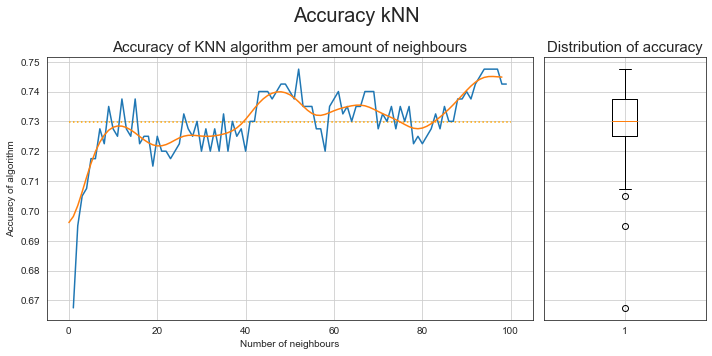

In [19]:
# Graph of accuracy of kNN at different amount of neighbours
fig, ax = plt.subplots(1,2,figsize=(10,5),sharey=True, gridspec_kw={'width_ratios': [3, 1]})
plt.suptitle('Accuracy kNN',size=20)

ax[0].plot(neighbours,scores_list)
y3 = gaussian_filter1d(scores_list, 3) #best number of neighbours is 46
ax[0].plot(y3) # gaussian filtered line to see the development of accuracy when number of neighbours changes
ax[0].hlines(np.average(scores_list),0,100, color='orange',linestyle='dotted') # for ease of comparison to boxplot
ax[0].set_title('Accuracy of KNN algorithm per amount of neighbours',size=15)
ax[0].set_xlabel('Number of neighbours')
ax[0].set_ylabel('Accuracy of algorithm')
ax[0].grid()

# Boxplot of data distribution
ax[1].boxplot(scores_list)
ax[1].set_title('Distribution of accuracy',size=15)
ax[1].grid()
plt.tight_layout()

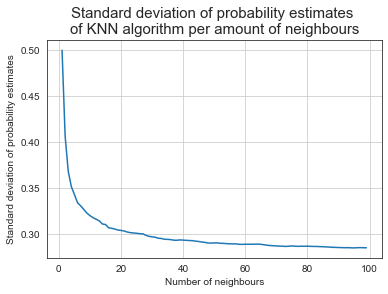

In [20]:
# Graph of the standard deviation of probability esitmates
plt.plot(neighbours,std_list)
plt.title('Standard deviation of probability estimates \nof KNN algorithm per amount of neighbours',size=15)
plt.xlabel('Number of neighbours')
plt.ylabel('Standard deviation of probability estimates')
plt.grid()

### Model quality evaluation

In [21]:
# Model quality parameters
av_recall = [] # or sensitivity
av_spec = [] # specificity
av_prec = [] # precision
av_acc = [] # accuracy
for confusionmatrix in knn_conf:
    confusionmatrix = pd.DataFrame(confusionmatrix)
    #partly from: https://stackoverflow.com/questions/31324218/scikit-learn-how-to-obtain-true-positive-true-negative-false-positive-and-fal
    FP = confusionmatrix[0][1]  
    FN = confusionmatrix[1][0]
    TP = confusionmatrix[1][1]
    TN = confusionmatrix[0][0]

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    #print('tp',TP,'fn',FN,'tpr',TPR)
    av_recall.append(TPR)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    av_spec.append(TNR)
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    av_prec.append(PPV)

    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
    av_acc.append(ACC)
print('Average recall is',np.average(av_recall))
print('Average specificity is',np.average(av_spec))
print('Average precision is',np.average(av_prec))
print('Average accuracy is',np.average(av_acc))
print('Average accuracy is',np.average(scores_list))

av_recall[47],av_spec[47],av_prec[47],av_acc[47]

Average recall is 0.5947942279861202
Average specificity is 0.7698033790950722
Average precision is 0.4292525252525253
Average accuracy is 0.7299494949494951
Average accuracy is 0.7299494949494951


(0.627906976744186, 0.7738853503184714, 0.432, 0.7425)

Text(0, 0.5, 'Statistic')

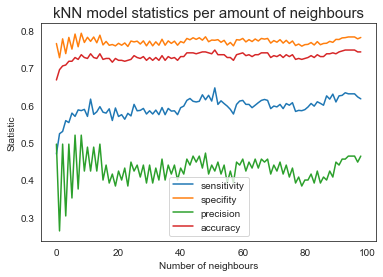

In [22]:
# Graph showing the relation between neighbours and important model statistics

plt.plot(av_recall,label='sensitivity')
plt.plot(av_spec,label='specifity')
plt.plot(av_prec,label='precision')
plt.plot(av_acc,label='accuracy')
plt.legend()
plt.title('kNN model statistics per amount of neighbours',size=15)
plt.xlabel('Number of neighbours')
plt.ylabel('Statistic')

### Actual model

In [23]:
# Fitting the model according to the same parameters as before
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state=32)
knn = KNeighborsClassifier(n_neighbors=36)
## Fit the model on the training data.
knn.fit(X_train, y_train)
X_train.head()

,PC1,PC2,PC3
567,-0.289720,-0.153989,-0.260813
1121,0.107573,-0.281576,-0.237661
1848,0.599707,0.562006,-0.114001
451,0.320105,-0.492170,0.255501
598,0.221918,-0.058000,0.037246


In [24]:
# Calculating the classification and certainty
output = knn.predict(pca_untested)
output_certainty = knn.predict_proba(pca_untested)
test_molecules['Inhibition'] = output
output_certainty = np.delete(output_certainty,0,axis=1) # Only keeping probability for inh='1'
test_molecules['Probability'] = output_certainty
test_molecules.head(-30)

,SMILES,Inhibition,Probability
0,CCCCC/C(=N\NC(=O)CCC(=O)NCc1ccccc1)c1ccccc1,0,0.500000
1,Cc1ccc(S(=O)(=O)N2CCC(C(=O)OCC(=O)N3CCc4ccccc4...,0,0.444444
2,COc1ccc(N2C(=O)CC(Nc3ccc(F)cc3)C2=O)c([N+](=O)...,0,0.472222
3,Cc1cc(C)cc(OCC(=O)O[NH+]=C(N)Cc2ccc([N+](=O)[O...,0,0.444444
4,NNC(=O)C=C1CCN(c2ncc(C(F)(F)F)cc2Cl)CC1,0,0.444444
...,...,...,...
9965,CCCn1c(NCc2ccco2)nc2c1c(=O)n(C)c(=O)n2C,0,0.472222
9966,CCCc1cc(O)nc(SCC(=O)c2c(N)n(C)c(=O)n(C)c2=O)n1,0,0.472222
9967,Cc1c(Br)cc(C(=O)NCCC[NH+]2CCOCC2)c(C)c1C,0,0.500000
9968,CCCCCn1cnc2c(sc3nc4c(cc32)CSC(C)(C)C4)c1=O,0,0.444444


Writing the final best 100 molecules to 'kNN_100_molecules.csv'

In [25]:
sorted_predict = test_molecules.sort_values('Probability', ascending=False) #Inhibitors at the top
sorted_predict[:100]['SMILES'].to_csv('kNN_100_molecules.csv')

# Support vector clustering

In [26]:
# Fit and test model
svc_scores_list = [] # List with accuracies
svc_conf = [] # list with confusion matrices

#Looking for variance in model performance depending on train-test split
for i in range(1,100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state=i)
    svc = SVC()
    svc.fit(X_train, y_train)
    svc_scores_list.append(svc.score(X_test,y_test))
    predict = svc.predict(X_test)
    
    cnf = confusion_matrix(y_test,predict)
    svc_conf.append(cnf)

### Model quality evaluation

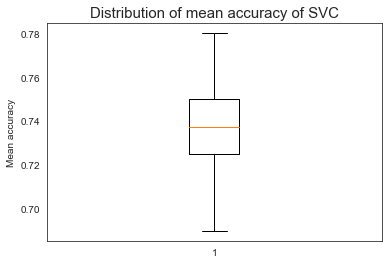

In [27]:
# Plots distribution of accuracy of SVC
plt.boxplot(svc_scores_list);
plt.title('Distribution of mean accuracy of SVC',size=15);
plt.ylabel('Mean accuracy');

In [28]:
# Model quality parameters
av_recall = [] # or sensitivity
av_spec = [] # specificity
av_prec = [] # precision
av_acc = [] # accuracy
for confusionmatrix in svc_conf:
    confusionmatrix = pd.DataFrame(confusionmatrix)
    #From: https://stackoverflow.com/questions/31324218/scikit-learn-how-to-obtain-true-positive-true-negative-false-positive-and-fal
    FP = confusionmatrix[0][1]  
    FN = confusionmatrix[1][0]
    TP = confusionmatrix[1][1]
    TN = confusionmatrix[0][0]

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    av_recall.append(TPR)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    av_spec.append(TNR)
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    av_prec.append(PPV)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)

    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
    av_acc.append(ACC)
print('Average recall is',np.average(av_recall))
print('Average specificity is',np.average(av_spec))
print('Average precision is',np.average(av_prec))
print('Average accuracy is',np.average(av_acc))

Average recall is 0.5830642818210329
Average specificity is 0.7835920514336118
Average precision is 0.44696062861571484
Average accuracy is 0.7365656565656568


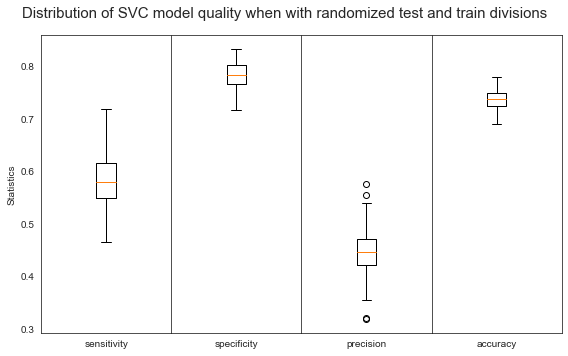

In [29]:
# Plot model quality parameters 

fig = plt.figure(figsize=(8,5))
gs = fig.add_gridspec(1, 4, wspace=0)
ax = gs.subplots(sharey=True)
ax[0].boxplot(av_recall,labels=['sensitivity'])
ax[1].boxplot(av_spec,labels=['specificity'])
ax[2].boxplot(av_prec,labels=['precision'])
ax[3].boxplot(av_acc,labels=['accuracy'])
plt.suptitle('Distribution of SVC model quality when with randomized test and train divisions',size=15)
ax[0].set_ylabel('Statistics')
plt.tight_layout()

### Actual model

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state=32)
svc = SVC()
svc.fit(X_train, y_train)s
svc_output = svc.predict(pd.DataFrame(pca_untested))
svc_prob = svc.decision_function(X_test)